In [1]:
import tensorflow as tf
import numpy as np

from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept import electrode2currentmap as e2cm

import matplotlib.pyplot as plt
%matplotlib inline

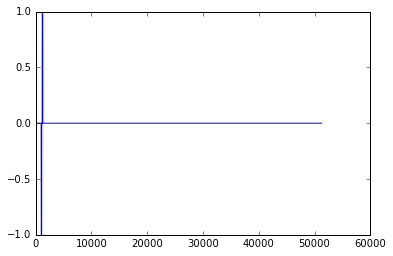

In [2]:
signal = e2cm.get_pulse(0.45 / 1000, 0.005 / 1000, 0.45 / 1000, 'cathodicfirst')
signal = np.concatenate((np.zeros(1000), signal, np.zeros(50000)))
plt.plot(signal)

In [3]:
def tf_conv(signal, gamma, tsample):
    if not isinstance(signal, tf.python.Tensor):
        # input tensor of shape [batch, in_width, in_channels]
        tf_signal = tf.constant(signal.reshape(1, -1, 1), name="signal", dtype=np.float32)
    else:
        tf_signal = signal
    
    if not isinstance(gamma, tf.python.Tensor):
        # filter tensor of shape [filter_width, in_channels, out_channels]
        tf_filter = tf.constant(gamma.reshape(-1, 1, 1), name="gamma_nfl", dtype=np.float32)
    else:
        tf_filter = gamma
    
    tf_conv = tf.nn.conv1d(tf_signal, tf_filter, stride=2, padding="SAME")
    tf_fr = tf_conv * tsample
    
    return tf_fr

In [4]:
def tf_stationary_nonlinearity(tf_signal, slope, shift):
    tf_max = tf.reduce_max(tf_signal)
    tf_scale = tf.sigmoid((tf_max - shift) / slope)
    return tf_signal / (tf_max + np.finfo(float).eps) * tf_scale

In [5]:
def tf_model_cascade(signal, tm):
    tf_fr = tf_conv(signal, tm.gamma_nfl, tm.tsample)
    tf_fr2 = tf.maximum(-tf_fr, 0) + tm.aweight * tf.maximum(tf_fr, 0)
    tf_sn = tf_stationary_nonlinearity(tf_fr2, tm.slope, tm.shift)
    tf_sr = tm.scale_slow * tf_conv(tf_sn, tm.gamma_slow, tm.tsample)
    
    out_tf_sr = tf.Session().run(tf_sr)
    return out_tf_sr

In [6]:
tm = ec2b.TemporalModel()
fr = tm.fast_response(signal, tm.gamma_nfl)
fr2 = np.maximum(-fr, 0) + tm.aweight * np.maximum(fr, 0)
sn = tm.stationary_nonlinearity(fr2)
sr = tm.slow_response(sn)

In [7]:
tf_out = tf_model_cascade(signal, tm)

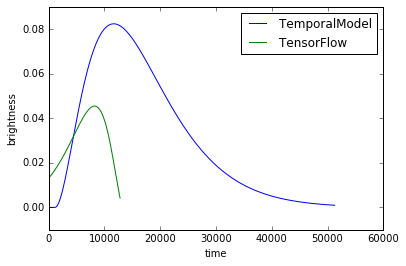

In [8]:
plt.plot(sr, label='TemporalModel')
plt.plot(tf_out.flatten(), label='TensorFlow')
plt.xlabel('time')
plt.ylabel('brightness')
plt.legend()